In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
os.chdir("../")
print(os.getcwd())
from parc.model import model_ns as model
from parc.data import data_navier_stokes as data
!nvidia-smi 


2024-05-27 12:06:21.537565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 12:06:23.883100: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/:/usr/local/cuda/include/:/usr/local/cuda/lib/:/usr/local/cuda/lib64/:/usr/lib/x86_64-linux-gnu/:/opt/apps/TensorRT-8.6.1.6/lib/:/opt/apps/TensorRT-8.6.1.6/include/:/usr/include/x86_64-linux-gnu/:/usr/include/
2024-05-27 12:06:23.883490: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

/home/lweger/PARCv2


2024-05-27 12:06:26.678963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 12:06:26.856713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:41:00.0, compute capability: 8.0


Mon May 27 12:06:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A30                     On  |   00000000:41:00.0 Off |                    0 |
| N/A   39C    P0             31W /  165W |     235MiB /  24576MiB |      2%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Data pipeline

In [2]:
Re_list = [7000,9000]    # all present data
train_list = [9000]    
test_list = [7000]

data_ns = data.DataNS(Re_list)
seq_input = data_ns.import_data(folder_path='./data/ns/')
seq_norm = data_ns.data_normalization(input_data=seq_input, no_of_channel=3)

train_seq, test_seq = data_ns.train_test_split(Re_list=Re_list, Re_test=test_list, Re_train=train_list,input_data=seq_norm[0])
train_data = data_ns.clip_data(input_seq=train_seq,no_of_fields=3,sequence_length=13)

# Validation

## Load model

In [3]:
tf.keras.backend.clear_session()
parc = model.PARCv2_ns(n_time_step = 37, step_size= 1/38, solver = "heun", use_data_driven_int = False, mode = "differentiator_training")
parc.differentiator.load_weights('./Pretrained_Weights/ns/parc2_diff_TEST_ns_heun_12.h5')
parc.poisson.load_weights('./Pretrained_Weights/ns/parc2_poisson_TEST_ns_heun_12.h5')
parc.integrator.load_weights('./Pretrained_Weights/ns/parc2_int_TEST_ns_heun_12.h5')
parc.compile()

In [4]:
pred_whole =[]
for idx in range(1):
    input_seq_current = tf.cast(test_seq[idx:idx+1,:,:,:3], dtype = tf.float32)
    output = parc.predict(input_seq_current)
    pred_whole.append(output)
pred = np.concatenate(pred_whole,axis = 0)

2024-05-27 12:06:52.671934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700


1/1 [==============================] - 25s 25s/step


In [5]:
y_pred_denorm = data_ns.data_denormalization(pred,seq_norm[1], seq_norm[2], no_of_channel = 3)

In [6]:
np.save('parcv2_ns.npy',y_pred_denorm)

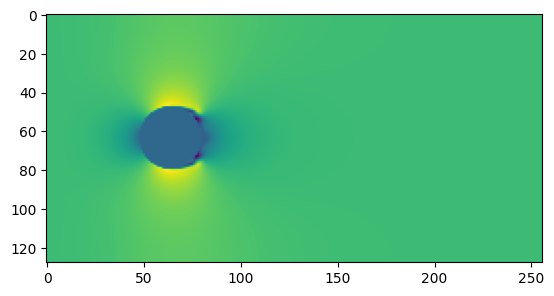

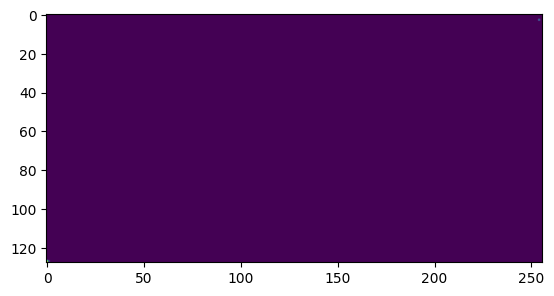

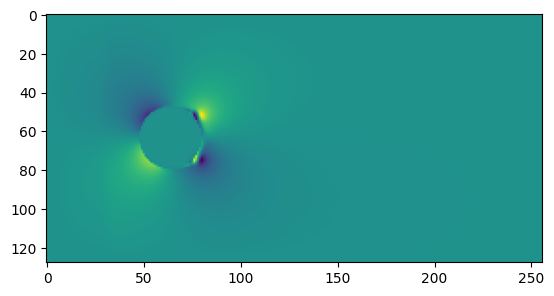

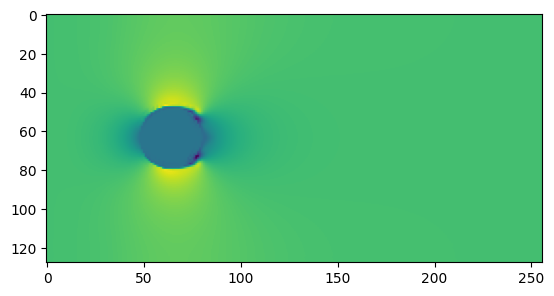

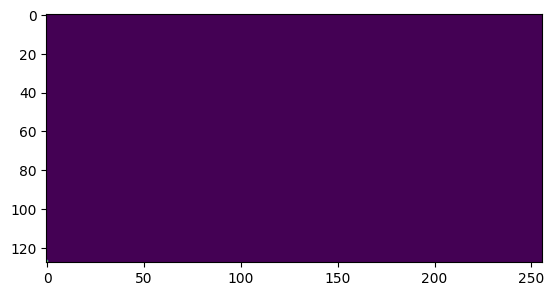

In [7]:
for i in range(5):
    plt.imshow(y_pred_denorm[0,:,:,(i*5)+0])
    plt.show()